# CardioRisk Advisor: Cuff-less Blood Pressure Estimation Using AI

This project introduces the first stage of the CardioRisk Advisor system — a machine learning-powered tool that estimates an individual's systolic and diastolic blood pressure using wearable PPG signals. 

Unlike traditional cuff-based methods, this approach leverages photoplethysmogram (PPG) data collected from sensors like smartwatches to predict blood pressure in real time. These estimated values will eventually be used as input features for our heart disease risk classification model.

In this notebook, we focus on training and evaluating models that can estimate **Systolic Blood Pressure (SBP)** and **Diastolic Blood Pressure (DBP)** from raw PPG segments.


# Dataset Overview

We use the publicly available **Cuff-less Blood Pressure Estimation Dataset** from Mohammad Kachuee. Specifically, we work with `part_1.mat` through `part_5.mat`, each containing 1000 samples of physiological signals. Each sample is a short recording composed of:

- Row 0: PPG (photoplethysmogram) — our input
- Row 1: ABP (arterial blood pressure waveform) — used to compute SBP and DBP
- Row 2: ECG — not used in this phase

Each PPG segment is 125 time steps long, and its corresponding SBP and DBP are extracted from the ABP waveform using the max and min values of that segment.


# Signal Preprocessing

We segment each PPG and BP waveform into fixed-size windows of 125 samples. For each window, we store:
- The normalized PPG waveform as our model input
- The **maximum** of the BP segment as the systolic pressure (SBP)
- The **minimum** of the BP segment as the diastolic pressure (DBP)

This yields a supervised learning dataset where each input-output pair represents a brief physiological snapshot of one heartbeat.


In [18]:
from scipy.io import loadmat
import numpy as np 
import pandas as pd 
import seaborn as sns 
from scipy import signal 
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import os 
os.listdir('./Dataset')


['part_12.mat',
 'part_5.mat',
 'part_4.mat',
 'part_11.mat',
 'part_6.mat',
 'part_7.mat',
 'part_10.mat',
 'part_3.mat',
 '.DS_Store',
 'part_2.mat',
 'part_1.mat',
 'Samples',
 'part_9.mat',
 'part_8.mat']

In [19]:
def extract_ppg_bp_from_file(filepath, sample_size=125):
    mat = loadmat(filepath)
    data = mat['p']
    ppg_segments, sbp, dbp = [], [], []

    for i in range(data.shape[1]):
        sample = data[0, i]
        ppg = sample[0]
        bp = sample[1]
        if ppg.shape[0] < sample_size:
            continue
        for j in range(0, len(ppg) - sample_size, sample_size):
            ppg_seg = ppg[j:j + sample_size]
            bp_seg = bp[j:j + sample_size]
            ppg_segments.append(ppg_seg)
            sbp.append(np.max(bp_seg))
            dbp.append(np.min(bp_seg))
    return ppg_segments, sbp, dbp

# Combine all files
all_ppg, all_sbp, all_dbp = [], [], []

folder = 'Dataset'
for i in range(1, 6):
    filepath = os.path.join(folder, f'part_{i}.mat')
    ppg_segs, sbp_vals, dbp_vals = extract_ppg_bp_from_file(filepath)
    all_ppg.extend(ppg_segs)
    all_sbp.extend(sbp_vals)
    all_dbp.extend(dbp_vals)


X = np.array(all_ppg)
y = np.column_stack((all_sbp, all_dbp))

In [20]:
print("PPG shape:", X.shape)
print("BP shape:", y.shape)

PPG shape: (1164408, 125)
BP shape: (1164408, 2)


# Signal Visualization and EDA

Below, we plot an example PPG segment and visualize the distributions of SBP and DBP values extracted from the dataset.

We also check the correlation between SBP and DBP, and categorize SBP levels into Low, Normal, and High to observe class distribution for potential downstream classification.

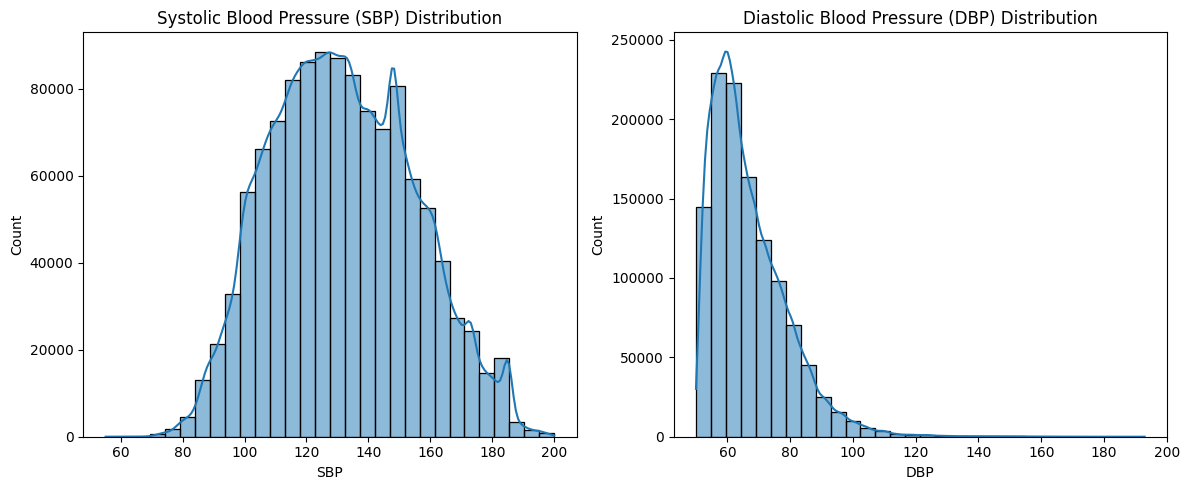

In [21]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(all_sbp, bins=30, kde=True)
plt.title('Systolic Blood Pressure (SBP) Distribution')
plt.xlabel('SBP')

plt.subplot(1, 2, 2)
sns.histplot(all_dbp, bins=30, kde=True)
plt.title('Diastolic Blood Pressure (DBP) Distribution')
plt.xlabel('DBP')
plt.tight_layout()
plt.show()


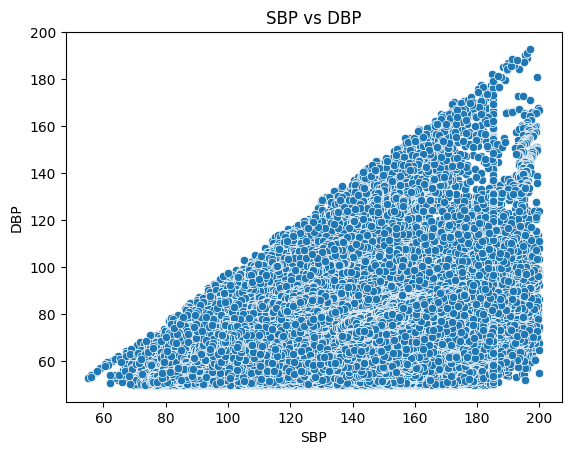

Correlation:           SBP       DBP
SBP  1.000000  0.468296
DBP  0.468296  1.000000


In [22]:
df_bp = pd.DataFrame({'SBP': all_sbp, 'DBP': all_dbp})
sns.scatterplot(x='SBP', y='DBP', data=df_bp)
plt.title('SBP vs DBP')
plt.show()

print("Correlation:", df_bp.corr())


In [23]:
print("SBP: min =", np.min(all_sbp), ", max =", np.max(all_sbp), ", mean =", np.mean(all_sbp))
print("DBP: min =", np.min(all_dbp), ", max =", np.max(all_dbp), ", mean =", np.mean(all_dbp))


SBP: min = 55.154708664740255 , max = 199.9479008990615 , mean = 131.8793333416497
DBP: min = 50.0 , max = 192.90743155154965 , mean = 66.82935442975865


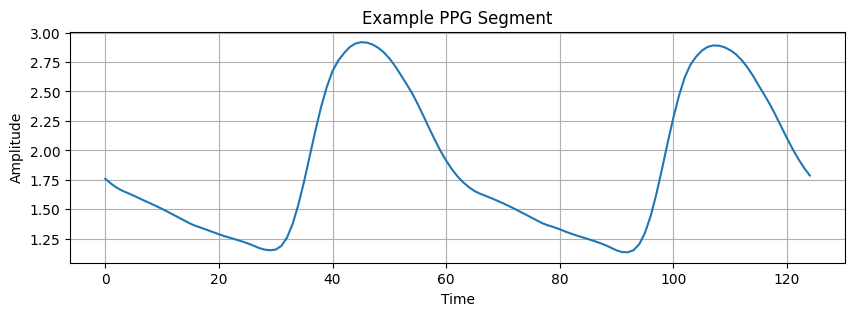

In [24]:
plt.figure(figsize=(10, 3))
plt.plot(all_ppg[0])
plt.title('Example PPG Segment')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()


In [25]:
df_bp['SBP_Class'] = pd.cut(df_bp['SBP'], bins=[0, 110, 130, 200], labels=['Low', 'Normal', 'High'])
print(df_bp['SBP_Class'].value_counts())

SBP_Class
High      594955
Normal    346947
Low       222506
Name: count, dtype: int64


# Baseline Model: Linear Regression

We start with a simple baseline model — linear regression. This model tries to learn a direct, linear mapping from the PPG waveform to SBP and DBP values.

It is fast and interpretable but limited in its ability to model complex relationships within the waveform.



In [26]:
# Normalize
X = (X - X.mean(axis=1, keepdims=True)) / X.std(axis=1, keepdims=True)
X_cnn = X[..., np.newaxis]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_cnn, y, test_size=0.2, random_state=42)



In [27]:
# Flatten inputs from (samples, 125, 1) → (samples, 125)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Train and predict
lr = LinearRegression()
lr.fit(X_train_flat, y_train)
y_pred_lr = lr.predict(X_test_flat)

# Evaluate
rmse_sbp = np.sqrt(mean_squared_error(y_test[:, 0], y_pred_lr[:, 0]))
rmse_dbp = np.sqrt(mean_squared_error(y_test[:, 1], y_pred_lr[:, 1]))

print("Linear Regression RMSE - SBP:", rmse_sbp)
print("Linear Regression RMSE - DBP:", rmse_dbp)

Linear Regression RMSE - SBP: 23.01427315559374
Linear Regression RMSE - DBP: 12.149834154315897


In [28]:
print("Mean:", np.mean(X))
print("Std:", np.std(X))


Mean: 1.512984304236457e-17
Std: 0.9999999999999998


# Deep Learning Model: 1D CNN

The 1D CNN model processes the waveform as a time series and extracts local patterns (such as peaks and slopes) that are indicative of blood pressure changes.

This architecture is ideal for signal processing and mimics how humans visually interpret waveform shape and rhythm.



In [30]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

def build_cnn(input_shape=(125, 1)):
    model = Sequential([
        Conv1D(32, 3, activation='relu', input_shape=input_shape),
        MaxPooling1D(2),
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(2)  # Predict SBP & DBP
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

cnn = build_cnn()
cnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)
cnn.save("cnn_bp_model_part1to5.h5")



Epoch 1/50
29111/29111 ━━━━━━━━━━━━━━━━━━━━ 77s 3ms/step - loss: 466.6418 - mae: 15.9094 - val_loss: 284.9417 - val_mae: 12.9528
Epoch 2/50
29111/29111 ━━━━━━━━━━━━━━━━━━━━ 77s 3ms/step - loss: 355.5687 - mae: 14.2151 - val_loss: 273.6417 - val_mae: 12.3064
Epoch 3/50
29111/29111 ━━━━━━━━━━━━━━━━━━━━ 74s 3ms/step - loss: 336.1693 - mae: 13.7405 - val_loss: 261.4543 - val_mae: 12.1453
Epoch 4/50
29111/29111 ━━━━━━━━━━━━━━━━━━━━ 76s 3ms/step - loss: 320.1006 - mae: 13.3638 - val_loss: 253.2081 - val_mae: 11.9643
Epoch 5/50
29111/29111 ━━━━━━━━━━━━━━━━━━━━ 75s 3ms/step - loss: 305.3416 - mae: 13.0068 - val_loss: 246.3357 - val_mae: 11.6455
Epoch 6/50
29111/29111 ━━━━━━━━━━━━━━━━━━━━ 75s 3ms/step - loss: 292.6052 - mae: 12.7014 - val_loss: 240.6779 - val_mae: 11.6031
Epoch 7/50
29111/29111 ━━━━━━━━━━━━━━━━━━━━ 80s 3ms/step - loss: 283.8719 - mae: 12.4889 - val_loss: 234.8253 - val_mae: 11.1982
Epoch 8/50
29111/29111 ━━━━━━━━━━━━━━━━━━━━ 76s 3ms/step - loss: 277.9684 - mae: 12.3347 - val_lo

# Deep Learning Model: Multilayer Perceptron (MLP)

The MLP is a feedforward neural network composed of multiple dense layers. It can learn nonlinear relationships between waveform features and blood pressure outputs.

We train this model using normalized, flattened PPG segments.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define MLP
mlp = Sequential([
    Dense(256, input_shape=(X_train_flat.shape[1],), activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(2)  # Output layer: SBP and DBP
])

# Compile
mlp.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train
mlp.fit(X_train_flat, y_train, validation_data=(X_test_flat, y_test), epochs=50, batch_size=32)



Epoch 1/50
29111/29111 ━━━━━━━━━━━━━━━━━━━━ 20s 681us/step - loss: 501.8863 - mae: 16.2946 - val_loss: 332.1177 - val_mae: 14.4206
Epoch 2/50
29111/29111 ━━━━━━━━━━━━━━━━━━━━ 19s 667us/step - loss: 377.0735 - mae: 14.7056 - val_loss: 304.3210 - val_mae: 13.2836
Epoch 3/50
29111/29111 ━━━━━━━━━━━━━━━━━━━━ 19s 663us/step - loss: 356.0578 - mae: 14.2900 - val_loss: 300.0873 - val_mae: 13.3109
Epoch 4/50
29111/29111 ━━━━━━━━━━━━━━━━━━━━ 19s 666us/step - loss: 337.0272 - mae: 13.9186 - val_loss: 291.0803 - val_mae: 13.1782
Epoch 5/50
29111/29111 ━━━━━━━━━━━━━━━━━━━━ 19s 665us/step - loss: 324.7121 - mae: 13.6449 - val_loss: 279.8983 - val_mae: 12.7514
Epoch 6/50
29111/29111 ━━━━━━━━━━━━━━━━━━━━ 19s 664us/step - loss: 318.1629 - mae: 13.4765 - val_loss: 274.5089 - val_mae: 12.5216
Epoch 7/50
29111/29111 ━━━━━━━━━━━━━━━━━━━━ 20s 668us/step - loss: 311.1454 - mae: 13.3209 - val_loss: 272.7804 - val_mae: 12.4375
Epoch 8/50
29111/29111 ━━━━━━━━━━━━━━━━━━━━ 19s 666us/step - loss: 306.3628 - mae: 

# Model Evaluation

We evaluate each model using two standard regression metrics:
- RMSE (Root Mean Squared Error) — penalizes larger errors more heavily
- MAE (Mean Absolute Error) — easier to interpret in real-world units (mmHg)

We also visualize actual vs. predicted values for both SBP and DBP, helping us assess how closely our models track true values.


## Linear Regression

📊 Linear Regression
  RMSE - SBP: 23.01 | DBP: 12.15
  MAE  - SBP: 18.98 | DBP: 9.38


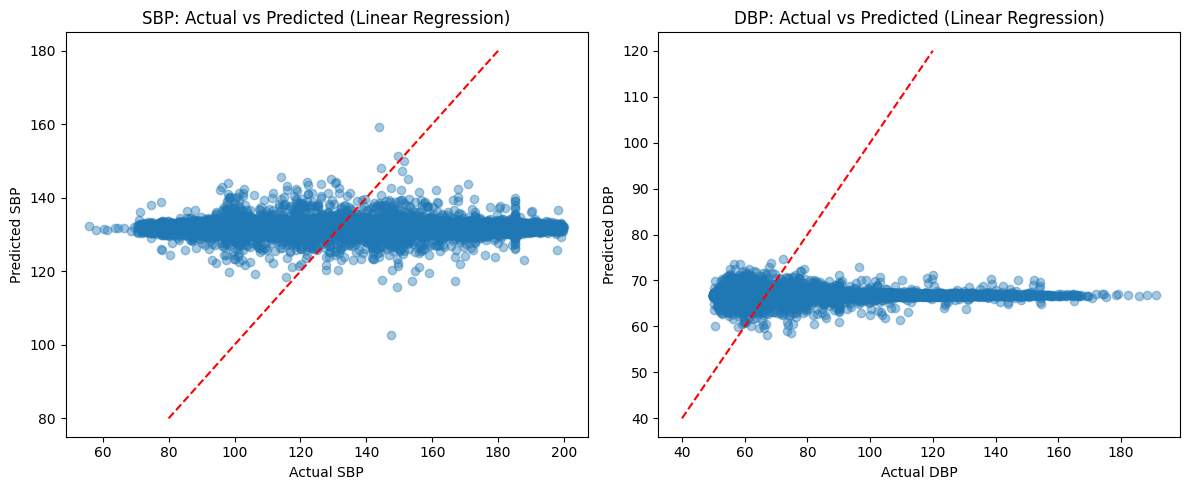

In [ ]:
# Predictions
y_pred_lr = lr.predict(X_test_flat)

# Metrics
rmse_sbp_lr = np.sqrt(mean_squared_error(y_test[:, 0], y_pred_lr[:, 0]))
rmse_dbp_lr = np.sqrt(mean_squared_error(y_test[:, 1], y_pred_lr[:, 1]))
mae_sbp_lr = mean_absolute_error(y_test[:, 0], y_pred_lr[:, 0])
mae_dbp_lr = mean_absolute_error(y_test[:, 1], y_pred_lr[:, 1])

print("Linear Regression")
print(f"  RMSE - SBP: {rmse_sbp_lr:.2f} | DBP: {rmse_dbp_lr:.2f}")
print(f"  MAE  - SBP: {mae_sbp_lr:.2f} | DBP: {mae_dbp_lr:.2f}")

# Plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test[:, 0], y_pred_lr[:, 0], alpha=0.4)
plt.plot([80, 180], [80, 180], 'r--')
plt.title("SBP: Actual vs Predicted (Linear Regression)")
plt.xlabel("Actual SBP")
plt.ylabel("Predicted SBP")

plt.subplot(1, 2, 2)
plt.scatter(y_test[:, 1], y_pred_lr[:, 1], alpha=0.4)
plt.plot([40, 120], [40, 120], 'r--')
plt.title("DBP: Actual vs Predicted (Linear Regression)")
plt.xlabel("Actual DBP")
plt.ylabel("Predicted DBP")
plt.tight_layout()
plt.show()



In [ ]:
# LR Cross-Validation on Training Data
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

sbp_cv_scores = cross_val_score(lr, X_train_flat, y_train[:, 0], cv=kf, scoring=rmse_scorer)
dbp_cv_scores = cross_val_score(lr, X_train_flat, y_train[:, 1], cv=kf, scoring=rmse_scorer)

print("Cross-Validation RMSE")
print(f"  SBP: {-np.mean(sbp_cv_scores):.2f} ± {np.std(sbp_cv_scores):.2f}")
print(f"  DBP: {-np.mean(dbp_cv_scores):.2f} ± {np.std(dbp_cv_scores):.2f}")


📉 Cross-Validation RMSE
  SBP: 23.03 ± 0.03
  DBP: 12.14 ± 0.02


## CNN

In [ ]:
# For CNN: model.predict(X_test) if model is cnn
y_pred_cnn = cnn.predict(X_test)  # or y_pred_mlp = mlp.predict(X_test_flat)

# Metrics
rmse_sbp_cnn = np.sqrt(mean_squared_error(y_test[:, 0], y_pred_cnn[:, 0]))
rmse_dbp_cnn = np.sqrt(mean_squared_error(y_test[:, 1], y_pred_cnn[:, 1]))

mae_sbp_cnn = mean_absolute_error(y_test[:, 0], y_pred_cnn[:, 0])
mae_dbp_cnn = mean_absolute_error(y_test[:, 1], y_pred_cnn[:, 1])

print(" CNN Model")
print(f"  RMSE - SBP: {rmse_sbp_cnn:.2f} | DBP: {rmse_dbp_cnn:.2f}")
print(f"  MAE  - SBP: {mae_sbp_cnn:.2f} | DBP: {mae_dbp_cnn:.2f}")


7278/7278 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step
🧠 CNN Model
  RMSE - SBP: 16.84 | DBP: 9.98
  MAE  - SBP: 12.84 | DBP: 7.16


In [34]:
print("Predicted SBP (first 10):", y_pred_cnn[:10, 0])
print("Predicted DBP (first 10):", y_pred_cnn[:10, 1])


Predicted SBP (first 10): [132.24977  138.83542  142.35254  126.190765 122.98653  151.6487
 145.74655  142.99503  125.41446  147.19951 ]
Predicted DBP (first 10): [63.962284 75.157745 57.997375 69.0523   66.676445 77.7632   70.46416
 77.38031  62.551342 70.918106]


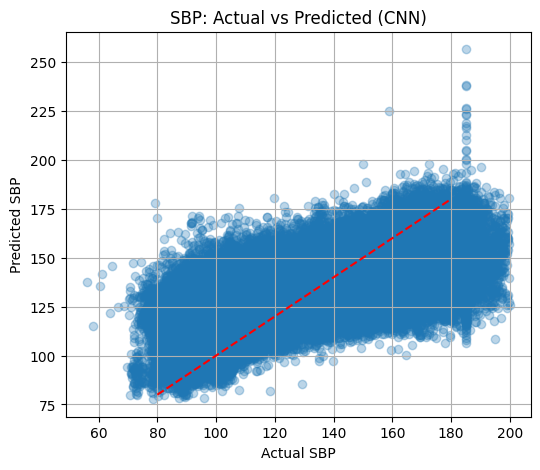

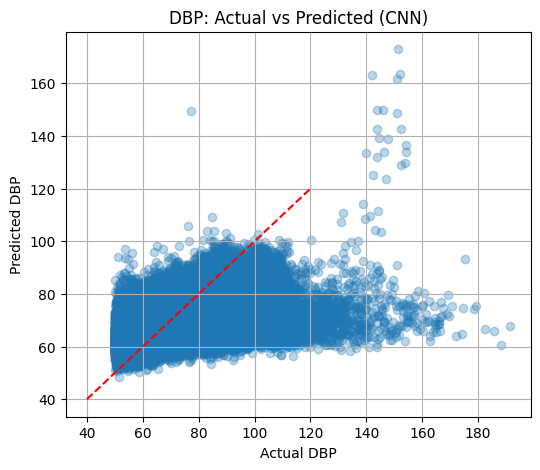

In [35]:
# SBP Scatter
plt.figure(figsize=(6, 5))
plt.scatter(y_test[:, 0], y_pred_cnn[:, 0], alpha=0.3)
plt.plot([80, 180], [80, 180], 'r--')  # Reference line (perfect prediction)
plt.title("SBP: Actual vs Predicted (CNN)")
plt.xlabel("Actual SBP")
plt.ylabel("Predicted SBP")
plt.grid(True)
plt.show()

# DBP Scatter
plt.figure(figsize=(6, 5))
plt.scatter(y_test[:, 1], y_pred_cnn[:, 1], alpha=0.3)
plt.plot([40, 120], [40, 120], 'r--')
plt.title("DBP: Actual vs Predicted (CNN)")
plt.xlabel("Actual DBP")
plt.ylabel("Predicted DBP")
plt.grid(True)
plt.show()

## MLP

7278/7278 ━━━━━━━━━━━━━━━━━━━━ 2s 234us/step
🔧 MLP Model
  RMSE - SBP: 18.73 | DBP: 10.70
  MAE  - SBP: 14.62 | DBP: 7.97


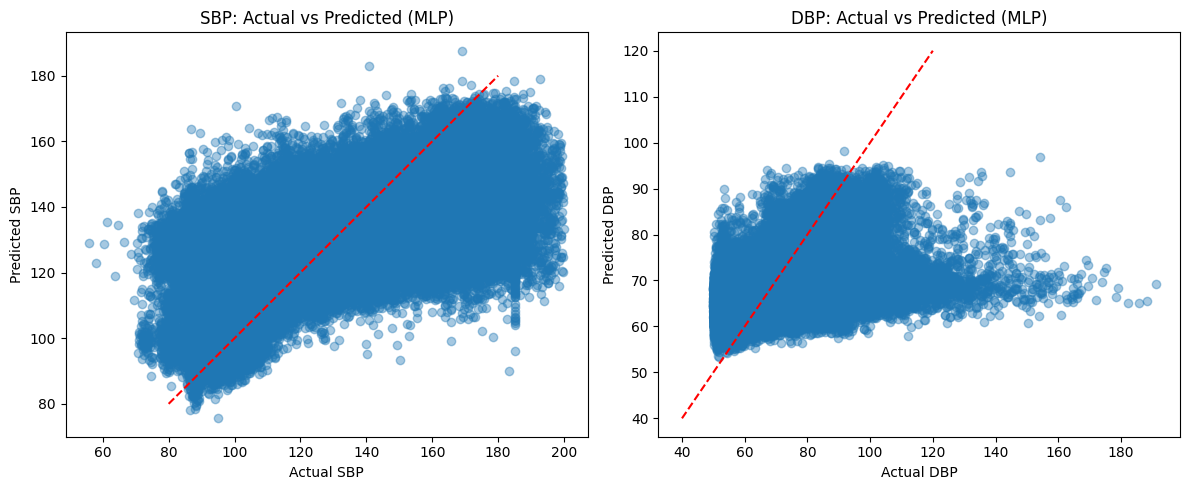

In [ ]:
# Predict with MLP
y_pred_mlp = mlp.predict(X_test_flat)

# Metrics
rmse_sbp_mlp = np.sqrt(mean_squared_error(y_test[:, 0], y_pred_mlp[:, 0]))
rmse_dbp_mlp = np.sqrt(mean_squared_error(y_test[:, 1], y_pred_mlp[:, 1]))
mae_sbp_mlp = mean_absolute_error(y_test[:, 0], y_pred_mlp[:, 0])
mae_dbp_mlp = mean_absolute_error(y_test[:, 1], y_pred_mlp[:, 1])

print(" MLP Model")
print(f"  RMSE - SBP: {rmse_sbp_mlp:.2f} | DBP: {rmse_dbp_mlp:.2f}")
print(f"  MAE  - SBP: {mae_sbp_mlp:.2f} | DBP: {mae_dbp_mlp:.2f}")

# Plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test[:, 0], y_pred_mlp[:, 0], alpha=0.4)
plt.plot([80, 180], [80, 180], 'r--')
plt.title("SBP: Actual vs Predicted (MLP)")
plt.xlabel("Actual SBP")
plt.ylabel("Predicted SBP")

plt.subplot(1, 2, 2)
plt.scatter(y_test[:, 1], y_pred_mlp[:, 1], alpha=0.4)
plt.plot([40, 120], [40, 120], 'r--')
plt.title("DBP: Actual vs Predicted (MLP)")
plt.xlabel("Actual DBP")
plt.ylabel("Predicted DBP")
plt.tight_layout()
plt.show()



# Improve the RNN Model

In [ ]:
from tensorflow.keras.models import load_model
#Change loss function

# 6. Build deeper CNN model with Huber loss
def build_cnn(input_shape=(125, 1)):
    model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(2),

        Conv1D(128, 3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(2),

        Conv1D(256, 3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(2),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(2)  # SBP and DBP
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=Huber(delta=10.0),
                  metrics=['mae'])
    return model

cnn = build_cnn()


In [39]:
# 7. Train the model with callbacks
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
]

history = cnn.fit(X_train, y_train,
                  validation_data=(X_test, y_test),
                  epochs=50,
                  batch_size=32,
                  callbacks=callbacks)


Epoch 1/50
29111/29111 ━━━━━━━━━━━━━━━━━━━━ 623s 21ms/step - loss: 112.0628 - mae: 15.4005 - val_loss: 75.8567 - val_mae: 11.5288 - learning_rate: 0.0010
Epoch 2/50
29111/29111 ━━━━━━━━━━━━━━━━━━━━ 506s 17ms/step - loss: 90.9171 - mae: 13.1597 - val_loss: 73.2893 - val_mae: 11.1866 - learning_rate: 0.0010
Epoch 3/50
29111/29111 ━━━━━━━━━━━━━━━━━━━━ 535s 18ms/step - loss: 86.5665 - mae: 12.6823 - val_loss: 72.5580 - val_mae: 11.1999 - learning_rate: 0.0010
Epoch 4/50
29111/29111 ━━━━━━━━━━━━━━━━━━━━ 459s 16ms/step - loss: 83.2662 - mae: 12.3221 - val_loss: 67.9539 - val_mae: 10.6288 - learning_rate: 0.0010
Epoch 5/50
29111/29111 ━━━━━━━━━━━━━━━━━━━━ 327s 11ms/step - loss: 80.7360 - mae: 12.0397 - val_loss: 66.5975 - val_mae: 10.4625 - learning_rate: 0.0010
Epoch 6/50
29111/29111 ━━━━━━━━━━━━━━━━━━━━ 322s 11ms/step - loss: 77.9760 - mae: 11.7350 - val_loss: 66.4622 - val_mae: 10.4563 - learning_rate: 0.0010
Epoch 7/50
29111/29111 ━━━━━━━━━━━━━━━━━━━━ 321s 11ms/step - loss: 76.0957 - mae:

KeyboardInterrupt: 

In [41]:
# 📊 8. Evaluate model
y_pred_cnn = cnn.predict(X_test)

rmse_sbp = np.sqrt(mean_squared_error(y_test[:, 0], y_pred_cnn[:, 0]))
rmse_dbp = np.sqrt(mean_squared_error(y_test[:, 1], y_pred_cnn[:, 1]))
mae_sbp = mean_absolute_error(y_test[:, 0], y_pred_cnn[:, 0])
mae_dbp = mean_absolute_error(y_test[:, 1], y_pred_cnn[:, 1])

print("📊 CNN Model Performance:")
print(f"  RMSE - SBP: {rmse_sbp:.2f} | DBP: {rmse_dbp:.2f}")
print(f"  MAE  - SBP: {mae_sbp:.2f} | DBP: {mae_dbp:.2f}")


7278/7278 ━━━━━━━━━━━━━━━━━━━━ 68s 9ms/step
📊 CNN Model Performance:
  RMSE - SBP: 17.53 | DBP: 10.03
  MAE  - SBP: 13.22 | DBP: 7.18


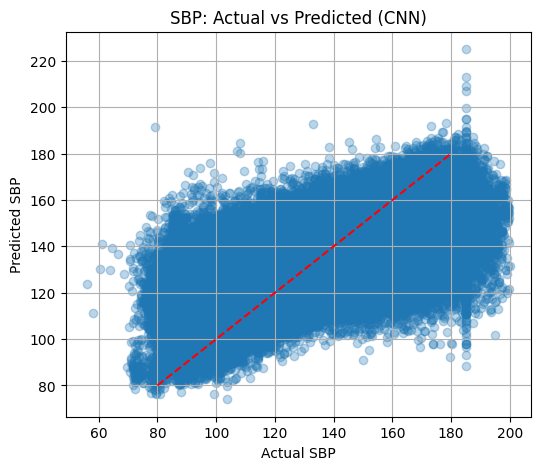

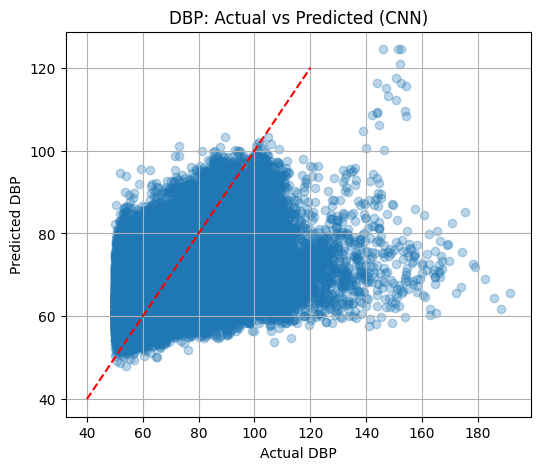

In [42]:
# 📈 9. Scatterplot: Actual vs Predicted
plt.figure(figsize=(6, 5))
plt.scatter(y_test[:, 0], y_pred_cnn[:, 0], alpha=0.3)
plt.plot([80, 180], [80, 180], 'r--')
plt.title("SBP: Actual vs Predicted (CNN)")
plt.xlabel("Actual SBP")
plt.ylabel("Predicted SBP")
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 5))
plt.scatter(y_test[:, 1], y_pred_cnn[:, 1], alpha=0.3)
plt.plot([40, 120], [40, 120], 'r--')
plt.title("DBP: Actual vs Predicted (CNN)")
plt.xlabel("Actual DBP")
plt.ylabel("Predicted DBP")
plt.grid(True)
plt.show()


### Improvements Made to CNN Model for Blood Pressure Estimation

| Change                        | Description                                                                 | Why It Helped                                                                 |
|------------------------------|-----------------------------------------------------------------------------|--------------------------------------------------------------------------------|
| Added Conv1D layers        | Increased from 2 to 3 convolutional layers with more filters (64 → 128 → 256) | Allowed the model to learn richer, hierarchical features in PPG waveforms     |
| Introduced BatchNormalization | Normalized outputs of each convolutional layer                               | Stabilized training, sped up convergence, and reduced internal covariate shift |
| Replaced MSE with Huber Loss | Used `Huber(delta=10.0)` instead of `mean_squared_error`                     | Balanced sensitivity to outliers with general fit; improved robustness         |
                                 |



# Save

In [40]:
cnn.save("cnn_model3.h5")

In [32]:
df_pred = pd.DataFrame(y_pred_cnn, columns=['Pred_SBP', 'Pred_DBP'])
df_pred.to_csv('predicted_bp_from_ppg2.csv', index=False)

NameError: name 'y_pred_cnn' is not defined

In [55]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError


# 1. 重新加载模型（不使用旧 optimizer 状态）
cnn = load_model("cnn_model2.h5", compile=False)

# 2. 手动 compile 新的 optimizer（不要用老的）
cnn.compile(
    optimizer=Adam(),
    loss='mse',
    metrics=['mae']
)
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
]

history = cnn.fit(X_train, y_train,
                  validation_data=(X_test, y_test),
                  epochs=50,
                  batch_size=32,
                  callbacks=callbacks)


Epoch 1/50
29111/29111 ━━━━━━━━━━━━━━━━━━━━ 492s 17ms/step - loss: 196.5580 - mae: 10.2091 - val_loss: 192.9109 - val_mae: 10.0128 - learning_rate: 0.0010
Epoch 2/50
29111/29111 ━━━━━━━━━━━━━━━━━━━━ 470s 16ms/step - loss: 195.4216 - mae: 10.1902 - val_loss: 189.9587 - val_mae: 9.9561 - learning_rate: 0.0010
Epoch 3/50
29111/29111 ━━━━━━━━━━━━━━━━━━━━ 467s 16ms/step - loss: 195.3954 - mae: 10.1767 - val_loss: 190.8603 - val_mae: 10.0319 - learning_rate: 0.0010
Epoch 4/50
29111/29111 ━━━━━━━━━━━━━━━━━━━━ 471s 16ms/step - loss: 194.5857 - mae: 10.1580 - val_loss: 189.1041 - val_mae: 9.9391 - learning_rate: 0.0010
Epoch 5/50
29111/29111 ━━━━━━━━━━━━━━━━━━━━ 825s 28ms/step - loss: 194.3279 - mae: 10.1541 - val_loss: 188.8955 - val_mae: 9.9041 - learning_rate: 0.0010
Epoch 6/50
29111/29111 ━━━━━━━━━━━━━━━━━━━━ 497s 17ms/step - loss: 193.4734 - mae: 10.1290 - val_loss: 188.5458 - val_mae: 9.8979 - learning_rate: 0.0010
Epoch 7/50
29111/29111 ━━━━━━━━━━━━━━━━━━━━ 490s 17ms/step - loss: 192.915

KeyboardInterrupt: 